# MNA - Master in Applied Artificial Intelligence
## Course: Fintech and Digital Innovation in Finance
### Course project part 1
#### Text embeddings and Technical Analysis on S&P 500 data (Section A)

---

**Student:** Emiliano Saucedo Arriola | A01659258  

**Date:** July 28th, 2025

---

# Introduction to text embeddings on S&P 500 news

## 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [1]:
!pip -q install pandas yfinance lxml -U sentence-transformers tqdm matplotlib

In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics import silhouette_score
import yfinance as yf
import numpy as np

/Users/emisaar/Documents/MNA/Verano/fintech/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get the list of stocks in the S&P 500 

In [3]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
ticker_list = df_tickers['Symbol'].tolist()
print(f"Sample tickers: {ticker_list[:5]}")

Sample tickers: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']


## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [5]:
# Create a dictionary where the keys are the symbols (tickers) of each 500 stocks 
# and the value is the output news from the yfinance library

from tqdm import tqdm
import random
import time

# Create a dictionary to store the news for each stock
news_dict = {}

# Loop through all tickers in the S&P 500
for ticker in tqdm(ticker_list, desc="Fetching news"):
    try:
        stock = yf.Ticker(ticker)
        news = stock.news
        news_dict[ticker] = news
        time.sleep(random.uniform(0.1, 0.2))
    except Exception as e:
        print(f"Error fetching news for {ticker}: {e}")
        news_dict[ticker] = []

Fetching news: 100%|██████████| 503/503 [03:08<00:00,  2.67it/s]


In [6]:
# Quick inspection of the news data structure
def print_schema(obj, indent=0):
    prefix = "  " * indent
    if isinstance(obj, dict):
        for key, value in obj.items():
            print(f"{prefix}{key}: {type(value).__name__}")
            print_schema(value, indent + 1)
    elif isinstance(obj, list) and obj:
        print(f"{prefix}[List of {type(obj[0]).__name__}]")
        print_schema(obj[0], indent + 1)

for ticker, news_list in news_dict.items():
    if news_list:
        print(f"\nSchema for first news in ticker: {ticker}")
        print_schema(news_list[0])
        break



Schema for first news in ticker: MMM
id: str
content: dict
  id: str
  contentType: str
  title: str
  description: str
  summary: str
  pubDate: str
  displayTime: str
  isHosted: bool
  bypassModal: bool
  previewUrl: NoneType
  thumbnail: dict
    originalUrl: str
    originalWidth: int
    originalHeight: int
    caption: str
    resolutions: list
      [List of dict]
        url: str
        width: int
        height: int
        tag: str
  provider: dict
    displayName: str
    url: str
  canonicalUrl: dict
    url: str
    site: str
    region: str
    lang: str
  clickThroughUrl: dict
    url: str
    site: str
    region: str
    lang: str
  metadata: dict
    editorsPick: bool
  finance: dict
    premiumFinance: dict
      isPremiumNews: bool
      isPremiumFreeNews: bool
  storyline: NoneType


### Structure the news into a pandas dataframe 

Your final dataframe should have the following columns: 
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [7]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Initialize a list to store structured news data
news_data = []

# Iterate through the news dictionary
for ticker, news_items in news_dict.items():
    for article in news_items:
        # Extract fields
        content = article.get('content', {})
        if isinstance(content, dict) and content:
            news_data.append(
                {
                    "TICKER": ticker,
                    "TITLE": content.get('title', None),
                    "SUMMARY": content.get('summary', None),
                    "PUBLICATION_DATE": pd.to_datetime(content.get('pubDate', None)),
                    "URL": content.get('canonicalUrl', {}).get('url', None)
                }
            )

In [8]:
# Create the DataFrame
df_news = pd.DataFrame(news_data)

# Show the shape and first few rows
display(df_news.head(5))

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
0,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21 09:45:00+00:00,https://finance.yahoo.com/news/zacks-industry-...
1,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21 08:22:00+00:00,https://finance.yahoo.com/news/stock-market-ne...
2,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19 07:05:47+00:00,https://finance.yahoo.com/news/3m-co-mmm-q2-20...
3,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19 05:30:58+00:00,https://finance.yahoo.com/news/mmm-q1-deep-div...
4,MMM,Dow Falls as Trump Reportedly Seeks Higher EU ...,The Dow Jones Industrial Average fell Friday f...,2025-07-18 21:11:10+00:00,https://finance.yahoo.com/news/dow-falls-trump...


In [9]:
# Brief summary
print("Missing values in the DataFrame:")
print("   TICKER:", df_news['TICKER'].isna().sum())
print("   TITLE:", df_news['TITLE'].isna().sum())
print("   SUMMARY:", df_news['SUMMARY'].isna().sum())
print("   PUBLICATION_DATE:", df_news['PUBLICATION_DATE'].isna().sum())
print("   URL:", df_news['URL'].isna().sum())
print("   Total missing values:", df_news.isna().sum().sum())
print("--" * 50)
print("Total number of articles:", df_news.shape[0])

Missing values in the DataFrame:
   TICKER: 0
   TITLE: 0
   SUMMARY: 0
   PUBLICATION_DATE: 0
   URL: 0
   Total missing values: 0
----------------------------------------------------------------------------------------------------
Total number of articles: 5016


## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [10]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Load the pre-trained embedding model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Add a column called 'EMBEDDED_TEXT'
df_news['EMBEDDED_TEXT'] = df_news['TITLE']

# Add a column called 'EMBEDDINGS'
embeddings = model.encode(df_news['EMBEDDED_TEXT'].tolist(), show_progress_bar=True)

# Assign to new column
df_news['EMBEDDINGS'] = embeddings.tolist()

Batches: 100%|██████████| 157/157 [00:05<00:00, 28.73it/s]


In [11]:
# Display the updated dataframe
display(df_news[['TICKER', 'EMBEDDED_TEXT', 'EMBEDDINGS']].head())

,TICKER,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","[-0.021629296243190765, -0.07978318631649017, ..."
1,MMM,"Stock Market News for Jul 21, 2025","[-0.03746960684657097, -0.043813712894916534, ..."
2,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,"[-0.08080153167247772, -0.029800741001963615, ..."
3,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,"[-0.019502609968185425, -0.07280398905277252, ..."
4,MMM,Dow Falls as Trump Reportedly Seeks Higher EU ...,"[0.01862616278231144, -0.03162859380245209, 0...."


## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [12]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Keep only the first occurrence of each ticker
df_news_500 = df_news.sort_values(by='PUBLICATION_DATE', ascending=False).drop_duplicates(subset='TICKER', keep='first')

# Ensure there are exactly 500
df_news_500 = df_news_500.head(500)
print(f"Number of unique tickers: {df_news_500.shape[0]}")
display(df_news_500.head())

Number of unique tickers: 500


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS
3636,PYPL,PayPal to launch cross-border platform with li...,MUMBAI (Reuters) -Payments firm PayPal has par...,2025-07-23 05:15:46+00:00,https://finance.yahoo.com/news/paypal-launch-c...,PayPal to launch cross-border platform with li...,"[-0.028456756845116615, -0.003977995365858078,..."
4380,TSLA,Which Mag 7 stocks will be the top performers ...,The latest earnings season will be another tes...,2025-07-23 05:00:28+00:00,https://uk.finance.yahoo.com/news/magnficent-7...,Which Mag 7 stocks will be the top performers ...,"[-0.039110664278268814, -0.10211867094039917, ..."
3449,NVDA,Which Mag 7 stocks will be the top performers ...,The latest earnings season will be another tes...,2025-07-23 05:00:28+00:00,https://uk.finance.yahoo.com/news/magnficent-7...,Which Mag 7 stocks will be the top performers ...,"[-0.039110664278268814, -0.10211867094039917, ..."
202,GOOG,Which Mag 7 stocks will be the top performers ...,The latest earnings season will be another tes...,2025-07-23 05:00:28+00:00,https://uk.finance.yahoo.com/news/magnficent-7...,Which Mag 7 stocks will be the top performers ...,"[-0.039110664278268814, -0.10211867094039917, ..."
3148,MSFT,Which Mag 7 stocks will be the top performers ...,The latest earnings season will be another tes...,2025-07-23 05:00:28+00:00,https://uk.finance.yahoo.com/news/magnficent-7...,Which Mag 7 stocks will be the top performers ...,"[-0.039110664278268814, -0.10211867094039917, ..."


### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [13]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Test k from 2 to 6
range_n_clusters = range(2, 7)
silhouette_scores = []

# Create the feature matrix
X = np.array(df_news_500['EMBEDDINGS'].to_list())

for k in range_n_clusters:
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X)
    
    # Compute silhouette score
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)
    
    print(f"k = {k} → Silhouette Score = {score:.4f}")

k = 2 → Silhouette Score = 0.0378
k = 3 → Silhouette Score = 0.0437
k = 4 → Silhouette Score = 0.0459
k = 5 → Silhouette Score = 0.0481
k = 6 → Silhouette Score = 0.0347


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Plot silhouette scores

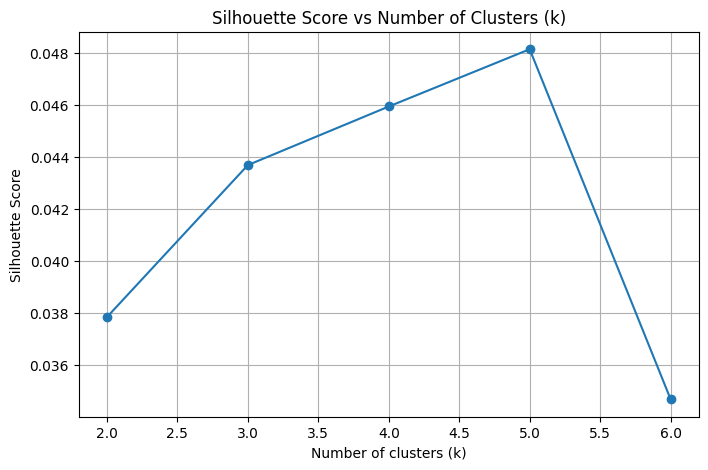

In [14]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

#### Identify the Best k

In [15]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

best_k = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Best k based on silhouette score: {best_k}")

Best k based on silhouette score: 5


#### Cluster the embeddings using 3 clusters (k=3)

In [16]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Run KMeans clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X)

# Add the cluster labels to the DataFrame
df_news_500['CLUSTER'] = cluster_labels

In [17]:
# Show a few sample rows with cluster assignment
display(df_news_500[['TICKER', 'TITLE', 'CLUSTER']].head(10))

,TICKER,TITLE,CLUSTER
3636,PYPL,PayPal to launch cross-border platform with li...,0
4380,TSLA,Which Mag 7 stocks will be the top performers ...,2
3449,NVDA,Which Mag 7 stocks will be the top performers ...,2
202,GOOG,Which Mag 7 stocks will be the top performers ...,2
3148,MSFT,Which Mag 7 stocks will be the top performers ...,2
3087,META,Which Mag 7 stocks will be the top performers ...,2
193,GOOGL,Which Mag 7 stocks will be the top performers ...,2
222,AMZN,Which Mag 7 stocks will be the top performers ...,2
382,AAPL,Which Mag 7 stocks will be the top performers ...,2
976,CVX,Oil Edges Higher With Progress of US Trade Tal...,0


In [18]:
cluster_counts = df_news_500['CLUSTER'].value_counts().sort_index()
print("Companies per cluster:")
print(cluster_counts)

Companies per cluster:
CLUSTER
0    152
1    151
2    197
Name: count, dtype: int64


### Visualize the 2 first PCA Components of your embeddings

In [19]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Reduce embeddings to 2 dimensions using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Add PCA components to the DataFrame for plotting
df_news_500['PCA1'] = X_pca[:, 0]
df_news_500['PCA2'] = X_pca[:, 1]


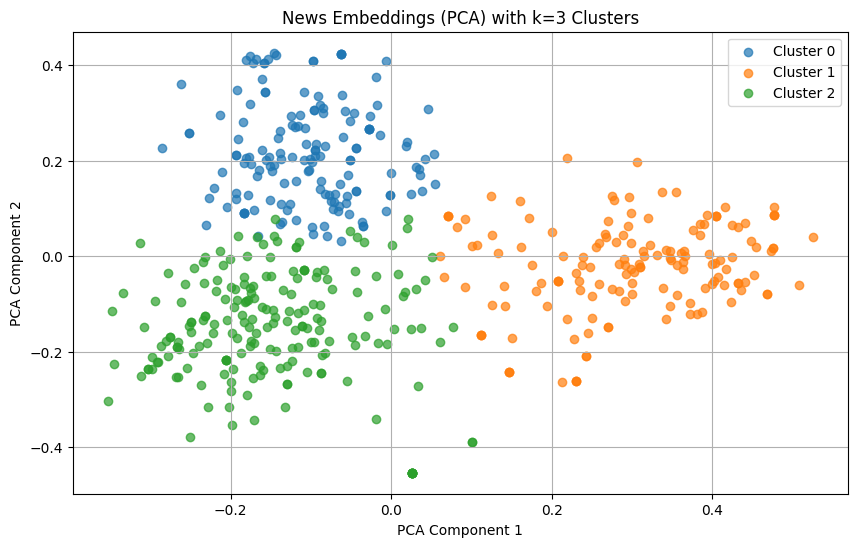

In [20]:
# Scatter plot by cluster
plt.figure(figsize=(10, 6))
for cluster_id in sorted(df_news_500['CLUSTER'].unique()):
    cluster_data = df_news_500[df_news_500['CLUSTER'] == cluster_id]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f"Cluster {cluster_id}", alpha=0.7)

plt.title("News Embeddings (PCA) with k=3 Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [21]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Print 5 sample news headlines per cluster
for cluster_id in sorted(df_news_500['CLUSTER'].unique()):
    print(f"\n=== Cluster {cluster_id} ===")
    sample_headlines = df_news_500[df_news_500['CLUSTER'] == cluster_id]['TITLE'].head(5).tolist()
    for i, title in enumerate(sample_headlines, 1):
        print(f"{i}. {title}")



=== Cluster 0 ===
1. PayPal to launch cross-border platform with link to India's UPI payments system
2. Oil Edges Higher With Progress of US Trade Talks in Spotlight
3. Starbucks Opens Free Study Rooms in China to Lure Customers
4. Advent-backed NIQ raises $1.05 billion in US IPO
5. Why Regency Centers, Tyson Foods, And Pfizer Are Winners For Passive Income

=== Cluster 1 ===
1. Union Pacific (UNP) Q2 Earnings: What To Expect
2. Deckers (DECK) Q2 Earnings: What To Expect
3. Pool (POOL) Reports Earnings Tomorrow: What To Expect
4. What To Expect From Tractor Supply’s (TSCO) Q2 Earnings
5. A. O. Smith (AOS) Reports Earnings Tomorrow: What To Expect

=== Cluster 2 ===
1. Which Mag 7 stocks will be the top performers this earnings season?
2. Which Mag 7 stocks will be the top performers this earnings season?
3. Which Mag 7 stocks will be the top performers this earnings season?
4. Which Mag 7 stocks will be the top performers this earnings season?
5. Which Mag 7 stocks will be the top per

In [ ]:
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Función para limpiar el texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS and len(t) > 2]
    return tokens


# Diccionario para guardar los conteos
cluster_keywords = {}

# Iterar sobre cada clúster
for cluster_id in sorted(df_news_500['CLUSTER'].unique()):
    titles = df_news_500[df_news_500['CLUSTER'] == cluster_id]['TITLE'].dropna().tolist()
    all_tokens = []
    for title in titles:
        all_tokens.extend(clean_text(title))
    
    # Contar las palabras más comunes
    word_counts = Counter(all_tokens).most_common(10)
    cluster_keywords[cluster_id] = word_counts

# Mostrar resultados
for cluster_id, words in cluster_keywords.items():
    print(f"\nCluster {cluster_id} — Top words:")
    for word, count in words:
        print(f"  {word}: {count}")



Cluster 0 — Top words:
  target: 18
  new: 17
  price: 17
  market: 15
  rating: 12
  trumps: 12
  buy: 11
  mergers: 11
  analyst: 10
  old: 9

Cluster 1 — Top words:
  earnings: 129
  report: 33
  expect: 24
  2025: 20
  stock: 20
  preview: 18
  strong: 15
  know: 14
  quarter: 13
  growth: 11

Cluster 2 — Top words:
  stock: 82
  stocks: 63
  dividend: 22
  buy: 19
  growth: 15
  market: 15
  earnings: 13
  value: 12
  week: 11
  tesla: 10




## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

> The choice of embedding model affects clustering through a trade-off between semantic depth and efficiency. Larger models capture finer nuances, leading to more coherent and interpretable clusters, while MiniLM offers speed and scalability at the cost of subtle meaning.

---

#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

> Using only the title gives a quick snapshot, while the summary adds context and nuance. Combining both can create richer embeddings, potentially improving clustering.

---

#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

> t-SNE and UMAP are preferable over PCA for visualizing embeddings when the primary goal is to reveal local clusters and preserve neighborhood relationships, especially in complex, non-linear data like semantic embeddings. They prioritize how similar items are grouped together, unlike PCA which focuses on maximizing variance.

---

### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

YOUR WRITTEN RESPONSE

---

#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

> Yes, a few points in the plot look isolated. In production, we can detect them by measuring distance to cluster centroids or checking low silhouette scores.

---

#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

> Based on the top keywords, Cluster 0 includes terms like target, price, rating, and mergers, suggesting a focus on analyst opinions and corporate actions not directly tied to earnings. Cluster 1, with dominant terms like earnings, report, quarter, and preview, is clearly centered on quarterly financial results and expectations. Cluster 2 features words like stock, dividend, growth, and buy, pointing to broader investment ideas and stock performance discussions. I’m highly confident in the interpretation of Cluster 1, while Clusters 0 and 2 show more thematic variety, making the labeling less precise. To validate these assignments, keyword frequency analysis (as the one done previously), topic modeling, and manual review could be combined for stronger support.

---

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

> Incorporating news sentiment would lead to clusters differentiated by both content and emotion, such as "Positive Earnings" or "Negative Corporate News." This creates more actionable financial insights, allowing for strategies driven by both what the news is and how it's perceived.

---

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?

> K-Means isn't always the best for news embeddings since it assumes clusters are round and evenly sized, which isn't how text data usually behaves. Methods like DBSCAN or HDBSCAN are better when clusters have weird shapes or different densities. And if the topics overlap or aren’t clearly separated, something like hierarchical or spectral clustering might make more sense.

---

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.

High-level pipeline:

1. **News Processing**
   * Collect S\&P 500 news headlines/summaries.
   * Generate embeddings using `all-MiniLM-L6-v2` or other models such as Gemma.
   * Cluster the embeddings using K-Means.

2. **Stock Price Alignment**
   * For each article, fetch the related stock’s price using its ticker and date.
   * Align news with price changes over a 1–3 day window.

3. **Label Generation**
   * Calculate % price change after the news.
   * Label each article as **Positive**, **Negative**, or **Neutral** based on defined thresholds (e.g., ±0.5%).

4. **Analysis & Insights**
   * Create a heatmap or table showing how stock movement types distribute across clusters.
   * Use statistical tests to check if clusters relate to stock price movement.

5. **Predictive Modeling**
   * Train a model using clusters, sentiment, and embeddings to predict movement labels.
   * Evaluate performance against a baseline.
   * Analyze which clusters or features drive predictions.

---

#### 🔟 Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

> Even if news clusters appear clear and meaningful, they often don't improve stock prediction. This is because the clusters might group news based on textual similarities that simply aren't relevant to price movements, or the market may have already reacted to the information before it was processed. Essentially, clustering aims to organize data, not predict future outcomes, so its groupings might not align with the actual drivers of stock performance."

